# Load Libraries

In [1]:
library(ggplot2)
library(cowplot)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# PCA summary plot for highly transcribed genes

The `nascentwt` pipeline performs DWT on a list of genes, then procceeds to performing PCA on the detail coefficients. The pipeline returns 

1. Detail coeffcients for each gene
2. Approximation coefficients for each gene
3. Summary of the PCA

        i. % variance explained by PC1 and PC2
        ii. PC1 and PC2 values for each sample per gene
        
        
## PCA results

In [2]:
pca_results_all <- read.table('../data/PCA_summary_sym5.tsv',
                     sep = '\t', header=FALSE)

colnames(pca_results_all) <-  c('geneID','pc1','pc2',
                          'pc1_R_gro', 'pc1_L_gro', 
                           'pc1_R_pro', 'pc1_L_pro')
head(pca_results_all)
dim(pca_results_all)

,geneID,pc1,pc2,pc1_R_gro,pc1_L_gro,pc1_R_pro,pc1_L_pro
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,RPL17-C18orf32,30.38,22.81,4,4,0,10
2,TIMM13,35.48,13.70,4,4,0,10
3,RPL8,36.28,17.40,8,0,1,9
4,SNHG3,51.48,21.40,0,8,5,5
5,MIR7111,52.25,20.12,8,0,0,10
6,GPX4,18.79,14.05,4,4,0,10


[1] 841   7

In [4]:
cv0.55_tpm150 <- read.table('../data/filtered_genes_cv0.55_tpm150.txt')
head(cv0.55_tpm150)
dim(cv0.55_tpm150)

,Chi_DMSO_S9,Chi_Nutlin_S10,DMSO_1_S1_R1_001,DMSO_2_S2_R1_001,DMSO_HCT116_RPI_26_S1_R1_001,GRO15_DMSO_062111_042215,GRO18_DMSO10_062111_042215,GRO20_DMSO100_062111_042215,i13_AGTCAA_L008_R1_001,i14_AGTTCC_L008_R1_001,⋯,SRR1105736,SRR1105737,SRR1105738,SRR1105739,SRR828696,stdev,variance,mean,median,coefvar
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OR51B5,194.5833,217.3396,33.90581,92.00847,78.6986,22.06616,212.9886,339.2758,303.4877,315.1482,⋯,131.8348,89.71403,160.3187,91.14861,157.1025,88.18898,7777.295,167.9770,173.4195,0.5250061
HMGA2,223.1193,246.0626,40.14329,128.45217,109.0519,46.80373,184.1352,221.7500,230.6041,230.2170,⋯,128.1851,84.82508,157.6145,104.98779,317.4584,75.98126,5773.152,173.4780,167.7396,0.4379880
DCBLD2,233.4016,280.3235,58.33268,128.39742,111.2093,81.61121,247.5880,352.1222,274.7969,263.0912,⋯,115.1290,94.22335,143.2882,106.78887,327.3241,88.58189,7846.751,192.5260,181.5008,0.4601036
MIR31HG,291.9281,350.7752,48.63528,184.39023,156.1311,63.20852,220.4406,329.2291,274.3984,308.0299,⋯,121.1801,90.09769,184.7797,101.68272,336.2130,96.35944,9285.141,215.5291,197.0213,0.4470832
KITLG,213.7583,257.7954,25.96867,119.03966,104.1396,12.97868,134.3955,182.3831,254.7593,274.0797,⋯,116.4485,56.42292,174.4590,70.59619,165.9261,80.78378,6526.019,163.4073,174.5249,0.4943707
EZR,251.7938,267.8912,197.61477,274.40673,243.8394,184.91296,313.3723,361.0443,262.4123,238.6501,⋯,149.2468,131.57567,179.7790,143.46377,325.7238,72.43035,5246.156,236.0308,241.2448,0.3068682


[1] 294  29

In [5]:
pca_results <- pca_results_all[pca_results_all$geneID %in% rownames(cv0.55_tpm150),]
dim(pca_results)

[1] 294   7

## Genes whose PCA separate protocols on PC1 == 0

There are 8 GRO-seq samples and 10 PRO-seq samples. The number of protocols relative to PC1==0 line were reported in the summary table. Here we are summarizing the output.

In [6]:
split1 <- subset(pca_results, pc1_L_gro == 8 & pc1_R_pro == 10)
split2 <- subset(pca_results, pc1_R_gro == 8 & pc1_L_pro == 10)
split <- rbind(split1, split2)
dim(split)

[1] 117   7

## Genes that separate protocols in PC1 and PC2 space


In [7]:
can_split <- c("RPL8","SNHG3","RPS28","H3C2","ID3","RBM3","IMPDH2",
             "SRSF6","DDIT4","FADD","HMGN2","RACK1","RPL27","RPS23",
             "SNORD32A","SNHG8","RPS5","MID1IP1","SNX5","H4C2","RPS2",
             "RPS24","RPARP-AS1","RABGGTB","HSP90AB1","RPLP2","ANXA2",
             "UBA52","EEF2","SNHG1","EZR","TBCC","RPS7","ZFP36","LOC100129917",
             "EIF4G2","DANCR","RPL18","HSPE1","DLGAP1-AS1","SRSF3","RBM12B",
             "RPL13","RPS17","SLC25A3","NPM1","RPL28","RPS16","THUMPD3-AS1",
             "VPS28","EIF1","OST4","RPS20","RPS25","WDR83OS","ITPRID2","TRIB1",
             "RPS14","TREX1","RPL10", "RPS8","GABPB1-AS1","APRT","YTHDF3-AS1",
             "ID2","KMT2E-AS1","TMEM107","H1-0","PFN1","RPS12","H2AZ1","NOP56",
             "MMP24OS","PABPC1","CITED2","EREG","EIF5","ZFP36L2","RPL36",
             "ALDH1A3","TRIM28","SNORA73B","H2AC13","RPS27A","TPI1","B3GALT4",
             "PARTICL","SNHG12", "H3-3B","FTH1","HSPA8","EPB41L4A-AS1","RPS26",
             "H3C12","LINC01715","GAS5","LOC105274304","GADD45A","DKK1","IER2",
             "RPL13A","DDX5","H3C13","RPL19","RPS27", "MRPS34","RPL7","ZFP36L1",
             "RPS3A","RPL23A","SNHG7","TAF1D","DNAJC9","RPL12","IER3","SNHG25",
             "CALR","RCC1","HSPA5","H4-16","PLK2","RPS11","ATF4","OR51B5",
             "RPL15","SNHG29","HMGA1","PPIA","FUS","ERRFI1","KRT18","RPS3",
             "RPL5","MAT2A","CYCS","ZFAS1","ELF3","AREG","TUBA1B","SERTAD1",
             "DUSP1","NCBP2AS2","SLC38A2","GSTP1","CKS2","SNHG16","RGS2",
             "RPL18A","DLGAP1-AS2","MYC","H2AC17","ZC3H10","MT1E","UQCRQ",
             "RPS13","ENO1","NT5C","MRPL12","RPL17","OXLD1","RPL30","DDX39B-AS1")

length(can_split)

[1] 162

## Genes that can not separate the protocols

In [8]:
no_split <- c("RPL17-C18orf32","MIR3655","LINC01970","RPL7A","SFN","PPP1R15A",
           "MIF","MT2A","NORAD","KITLG","GADD45B","SNHG5","SNORA73A","SNHG9",
           "CCND1")
length(no_split)

[1] 15

# Loading PC1 and PC2 values

In [9]:
pc1 <- read.table('../data/PC1_results_sym5.tsv')
pc2 <- read.table('../data/PC2_results_sym5.tsv')
gene_ids <- read.table('../data/gene_names.tsv')
sample_ids <- read.table('../data/sample_names.tsv',sep = '\t')

In [10]:
rownames(pc1) <- gene_ids$V1
rownames(pc2) <- gene_ids$V1
colnames(pc1) <- sample_ids$V2
colnames(pc2) <- sample_ids$V2

In [11]:
pc1_gather <- as.data.frame(t(pc1)) %>% gather
pc1_gather$protocol <- rep(sample_ids$V2, nrow(pc1))
pc1_gather$lib_prep <- rep(sample_ids$V3, nrow(pc1))

In [12]:
pc2_gather <- as.data.frame(t(pc2)) %>% gather
pc2_gather$protocol <- rep(sample_ids$V2, nrow(pc2))
pc2_gather$lib_prep <- rep(sample_ids$V3, nrow(pc2))

## Order the genes based on PC separation

In [13]:
pca_results_pc1pc2 <- pca_results[pca_results$geneID %in% can_split,]

In [14]:
#separate PC1 plot, by protocols that dominate one of the other
#side of the PC1 space
split1_pc1pc2 <- subset(pca_results_pc1pc2, pc1_L_gro >= 6)
split2_pc1pc2 <- subset(pca_results_pc1pc2, pc1_L_gro < 6 ) 

In [15]:
##subset the pc1 values based on the separetability of the protocols
pc1_gather1 <- pc1_gather[pc1_gather$key %in% split1$geneID, ]
pc1_gather2 <- pc1_gather[pc1_gather$key %in% split2$geneID, ]
pc1_gather3 <- pc1_gather[pc1_gather$key %in% split1_pc1pc2$geneID, ]
pc1_gather4 <- pc1_gather[pc1_gather$key %in% split2_pc1pc2$geneID, ]
pc1_gather_no_sep <- pc1_gather[pc1_gather$key %in% no_split, ]

In [16]:
pc1_gather1$value <- pc1_gather1$value*-1
pc1_gather3$value <- pc1_gather3$value*-1

In [17]:
##combine the ordered pc1 genes
pc1_gather_new <- rbind(pc1_gather2,pc1_gather1,
                        pc1_gather3,pc1_gather4,
                        pc1_gather_no_sep)
pc1_gather_new$keys <- factor(pc1_gather_new$key,
                              levels=rev(unique(pc1_gather_new$key)))

In [18]:
##add bold highlight to genes we are compraring
gene_names <- unique(pc1_gather_new$keys)
plain_bold <- ifelse(gene_names %in% c("RPL32", "RPS3A","CCND1") ,
                     "bold","plain")

### Plot all 294 genes ordered

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


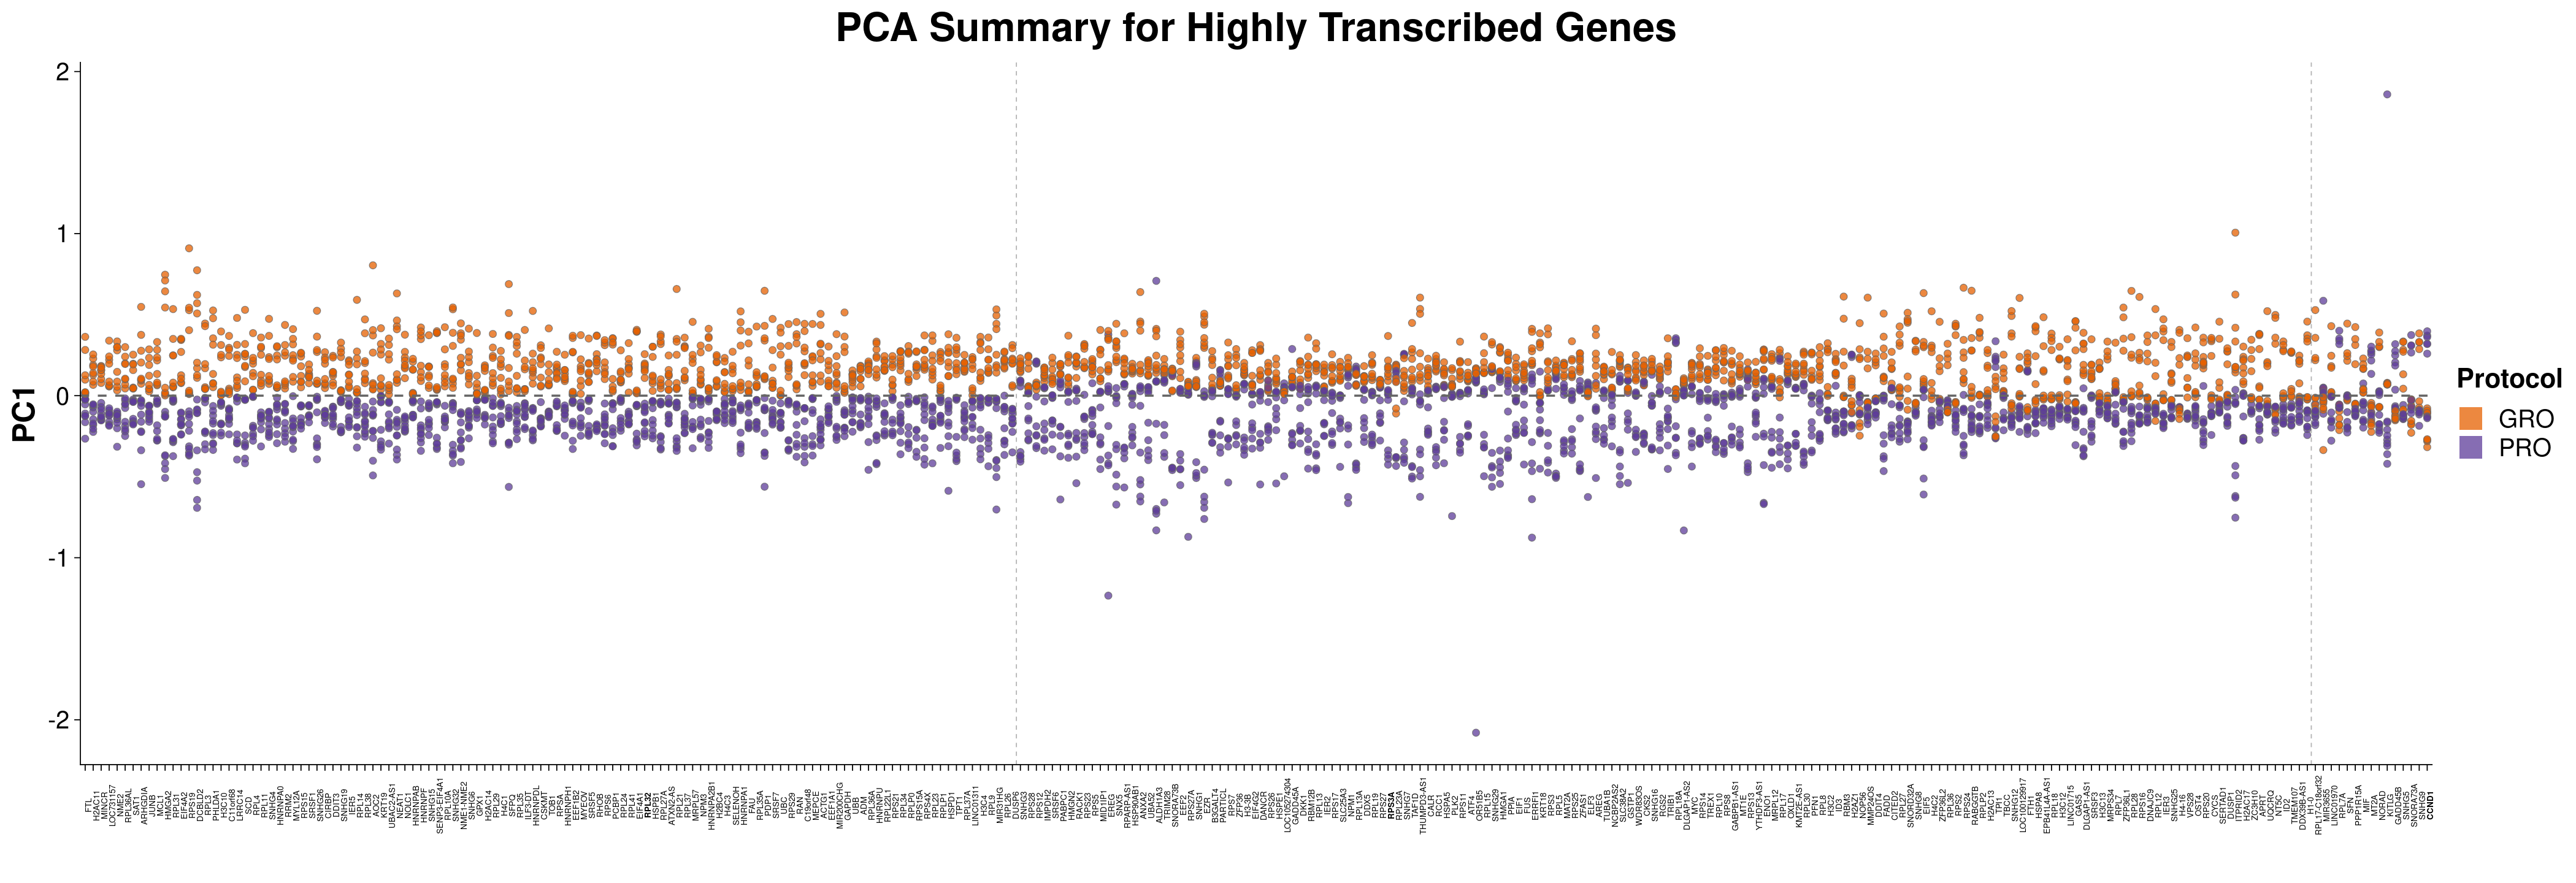

In [19]:
options(repr.plot.width=35, repr.plot.height=12)
pca_sum_plt <- ggplot(pc1_gather_new, 
                      aes(y=value, 
                          x=reorder(keys, desc(keys)), 
                          fill=protocol)) + 
ggtitle("PCA Summary for Highly Transcribed Genes") +
ylab('PC1') + 
xlab(' ') + 
geom_point(size=3, shape=21,color="gray40", alpha=0.75) + 
guides(fill = guide_legend(override.aes = list(shape = 15, 
                                               size = 10,
                                               col=c('#e66101','#5e3c99')))) +
geom_vline(xintercept = 117.5, col='gray40', lwd=0.5, alpha=0.5, linetype="dashed") +
geom_vline(xintercept = 279.5, col='gray40',lwd=0.5, alpha=0.5, linetype="dashed") +
scale_fill_manual(name='Protocol',
                  values = c('#e66101','#5e3c99')) +
geom_hline(yintercept=0, linetype="dashed", 
                color = "gray40", size=1) +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34, face = "bold"), 
      axis.title = element_text(size = 30, face = "bold"), 
      axis.text.x = element_text(size = 8, angle = 90, hjust = 0.5),
      axis.text.y = element_text(size = 24),
     legend.title = element_text(size = 26),
     legend.text = element_text(size = 24)) +
theme(axis.text.x = element_text(face = plain_bold))

pca_sum_plt

### UBB PCA plot

In [20]:
#subset UBB from the pc1 and pc2 dataframes
ubb_pc <- as.data.frame(t(rbind(pc1[rownames(pc1) %in% 'UBB',],
                                pc2[rownames(pc2) %in% 'UBB',])))

colnames(ubb_pc) <- c('PC1','PC2')
rownames(ubb_pc) <- sample_ids$V1
ubb_pc$Protocol <- sample_ids$V2
ubb_pc$Library <- sample_ids$V3
ubb_pc 

,PC1,PC2,Protocol,Library
,<dbl>,<dbl>,<fct>,<fct>
Chi_DMSO_S9.bedGraph,0.11044642,-0.049943752,PRO,LIG
Chi_Nutlin_S10.bedGraph,0.09148244,-0.039216018,PRO,LIG
DMSO_HCT116_RPI_26_S1_R1_001.bedGraph,0.06454327,-0.003279567,PRO,LIG
DMSO-1_S1_R1_001.bedGraph,0.01247995,0.171434392,PRO,TSRT
DMSO-2_S2_R1_001.bedGraph,0.01018457,0.170786038,PRO,TSRT
i13_AGTCAA_L008_R1_001.bedGraph,-0.05495669,-0.034072656,GRO,LIG
i14_AGTTCC_L008_R1_001.bedGraph,-0.08186341,-0.043035406,GRO,LIG
i17_GTAGAG_L008_R1_001.bedGraph,-0.13318894,-0.037166291,GRO,LIG
i18_GTCCGC_L008_R1_001.bedGraph,-0.15534838,-0.064933174,GRO,LIG


In [21]:
subset(pca_results_all, geneID =='UBB')

,geneID,pc1,pc2,pc1_R_gro,pc1_L_gro,pc1_R_pro,pc1_L_pro
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
34,UBB,25.5,18.55,0,8,10,0


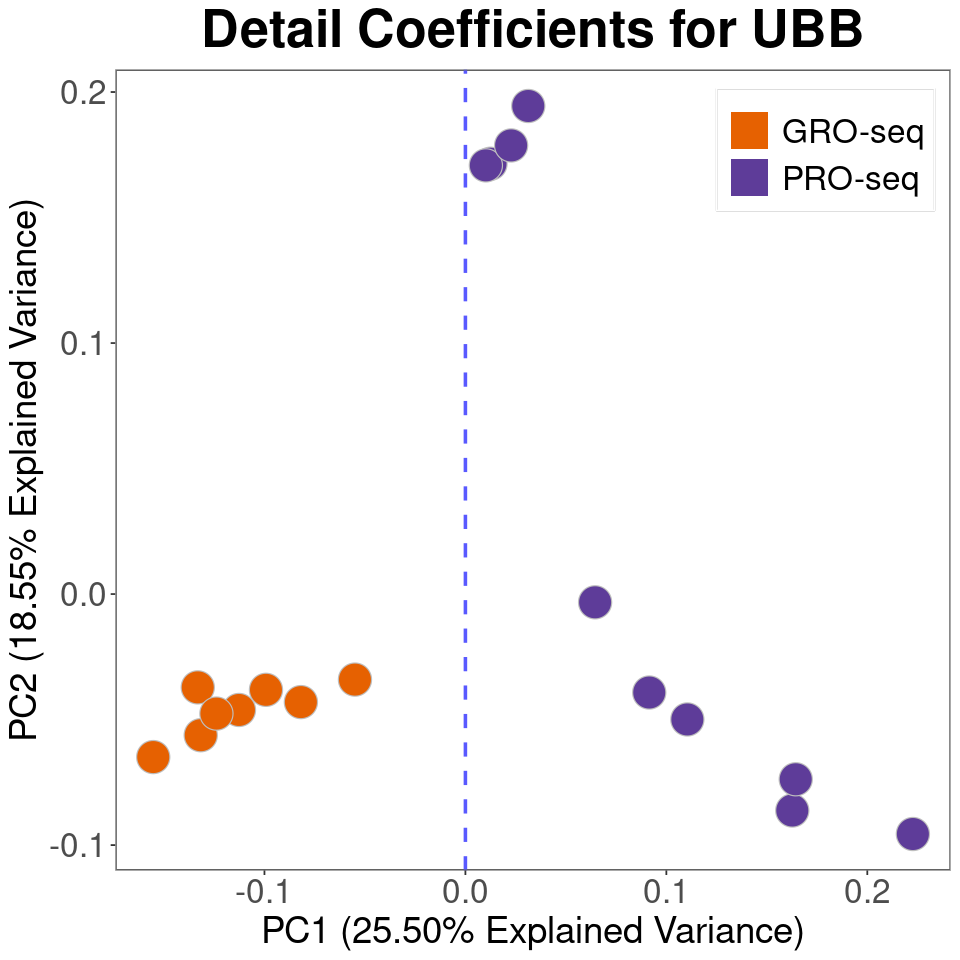

In [22]:
options(repr.plot.width=8, repr.plot.height=8)
ubb_pro_plot <- ggplot(ubb_pc, aes(PC1, PC2,fill=Protocol)) +
        xlab("PC1 (25.50% Explained Variance)") +
        ylab("PC2 (18.55% Explained Variance)") + 
        ggtitle('Detail Coefficients for UBB') +
        geom_point(size=9, shape=21,color="gray") +
        theme_bw() +
        geom_vline(xintercept=0, linetype="dashed", 
                    color = "blue", size=1, alpha=0.65) +
        guides(fill = guide_legend(override.aes = list(shape = 15, 
                                                   size = 10,
                                                  col=c('#e66101','#5e3c99')))) +
        scale_fill_manual(name="Protocol",
                          values = c('#e66101','#5e3c99'),
                         labels = c("GRO-seq", "PRO-seq")) +
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              panel.background = element_rect(colour = "black", size=0.75))+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),
              title = element_text(size = 26), 
              axis.title = element_text(size = 22), 
              axis.text = element_text(size = 20),
             legend.title =  element_blank(), 
             legend.text = element_text(size = 20)) +
        theme(
            panel.background = element_rect(fill = "white"), 
            panel.border = element_rect(colour = "gray", fill=NA),
            plot.background = element_rect(fill = "transparent", color = NA),
            legend.key = element_rect(colour = "transparent", 
                                      fill = "transparent"),
            legend.background = element_rect(fill = "transparent", 
                                             colour = 'white', 
                                             linetype='solid'), 
            legend.box.background = element_rect(fill = "transparent") 
            
        ) + theme(legend.position = c(0.85, 0.9))

ubb_pro_plot

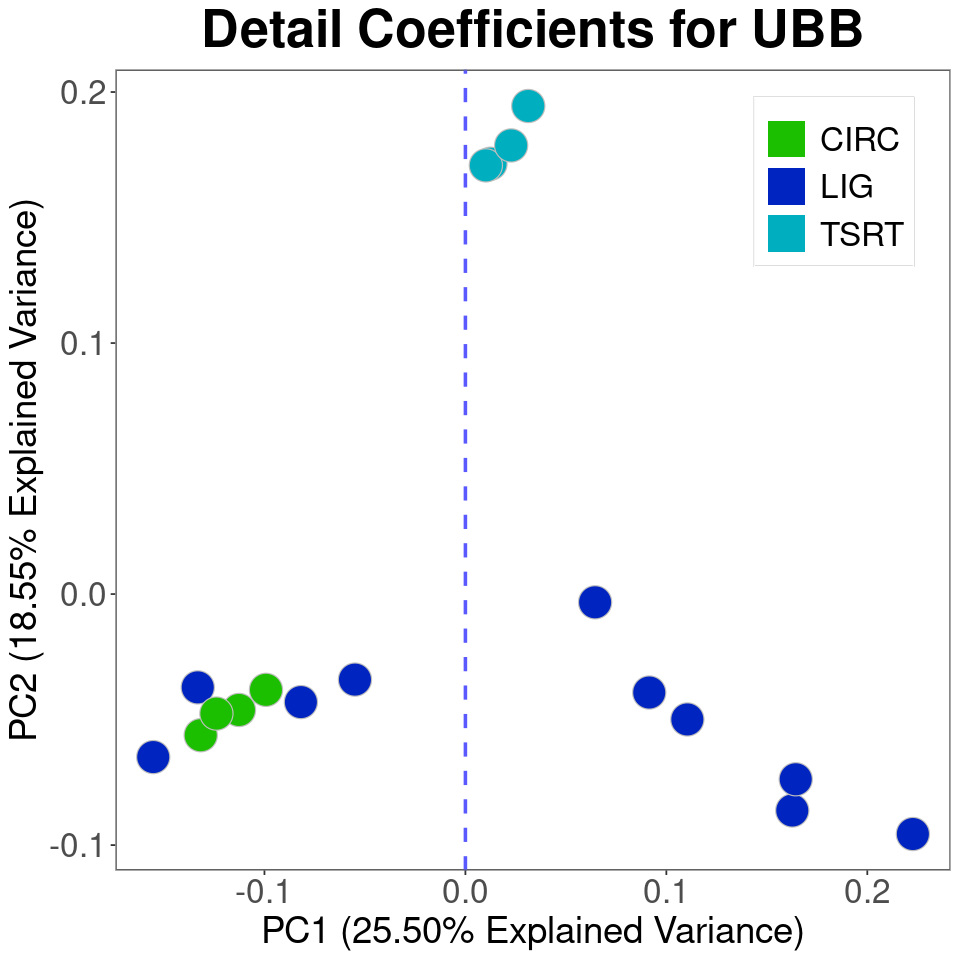

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
ubb_lib_plot <- ggplot(ubb_pc, aes(PC1, PC2,fill=Library)) +
        xlab("PC1 (25.50% Explained Variance)") +
        ylab("PC2 (18.55% Explained Variance)") + 
        ggtitle('Detail Coefficients for UBB') +
        geom_point(size=9, shape=21,color="gray") +
        theme_bw() +
        geom_vline(xintercept=0, linetype="dashed", 
                    color = "blue", size=1, alpha=0.65) +
        guides(fill = guide_legend(override.aes = list(shape = 15, 
                                                   size = 10,
                                                  col=c('#1CBF00',
                                                        '#0024BF',
                                                        '#00AFBF')))) +
        scale_fill_manual(name="    Library",
                          values = c('#1CBF00','#0024BF','#00AFBF'),
                         labels = c("CIRC","LIG", "TSRT")
                         ) +
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              panel.background = element_rect(colour = "black", size=0.75))+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),
              title = element_text(size = 26), 
              axis.title = element_text(size = 22), 
              axis.text = element_text(size = 20),
             legend.title =  element_blank(), 
             legend.text = element_text(size = 20)) +
        theme(
            panel.background = element_rect(fill = "white"),
            panel.border = element_rect(colour = "gray", fill=NA),
            plot.background = element_rect(fill = "transparent",
                                           color = NA), 
            legend.key = element_rect(colour = "transparent", 
                                      fill = "transparent"),
            legend.background = element_rect(fill = "transparent",
                                             colour = 'white',
                                             linetype='solid'), 
            legend.box.background = element_rect(fill = "transparent") 
            
        ) + theme(legend.position = c(0.86, 0.86))

ubb_lib_plot

### RPL32 PCA plot [Separates on PC1]

In [24]:
##subseting gene of interest
rpl32_pc <- as.data.frame(t(rbind(pc1[rownames(pc1) %in% 'RPL32',],
                                pc2[rownames(pc2) %in% 'RPL32',])))

colnames(rpl32_pc) <- c('PC1','PC2')
rownames(rpl32_pc) <- sample_ids$V1
rpl32_pc$Protocol <- sample_ids$V2
rpl32_pc$Library <- sample_ids$V3
rpl32_pc 

,PC1,PC2,Protocol,Library
,<dbl>,<dbl>,<fct>,<fct>
Chi_DMSO_S9.bedGraph,-0.07082163,0.15190995,PRO,LIG
Chi_Nutlin_S10.bedGraph,-0.09317804,0.18963673,PRO,LIG
DMSO_HCT116_RPI_26_S1_R1_001.bedGraph,-0.10225704,-0.06024252,PRO,LIG
DMSO-1_S1_R1_001.bedGraph,-0.23553603,-0.17436808,PRO,TSRT
DMSO-2_S2_R1_001.bedGraph,-0.25125990,-0.19626542,PRO,TSRT
i13_AGTCAA_L008_R1_001.bedGraph,0.17393659,-0.05089149,GRO,LIG
i14_AGTTCC_L008_R1_001.bedGraph,0.18402227,-0.06109737,GRO,LIG
i17_GTAGAG_L008_R1_001.bedGraph,0.19850586,-0.09496031,GRO,LIG
i18_GTCCGC_L008_R1_001.bedGraph,0.25610068,-0.14899321,GRO,LIG


In [25]:
subset(pca_results_all, geneID =='RPL32')

,geneID,pc1,pc2,pc1_R_gro,pc1_L_gro,pc1_R_pro,pc1_L_pro
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
618,RPL32,26.59,18.43,8,0,0,10


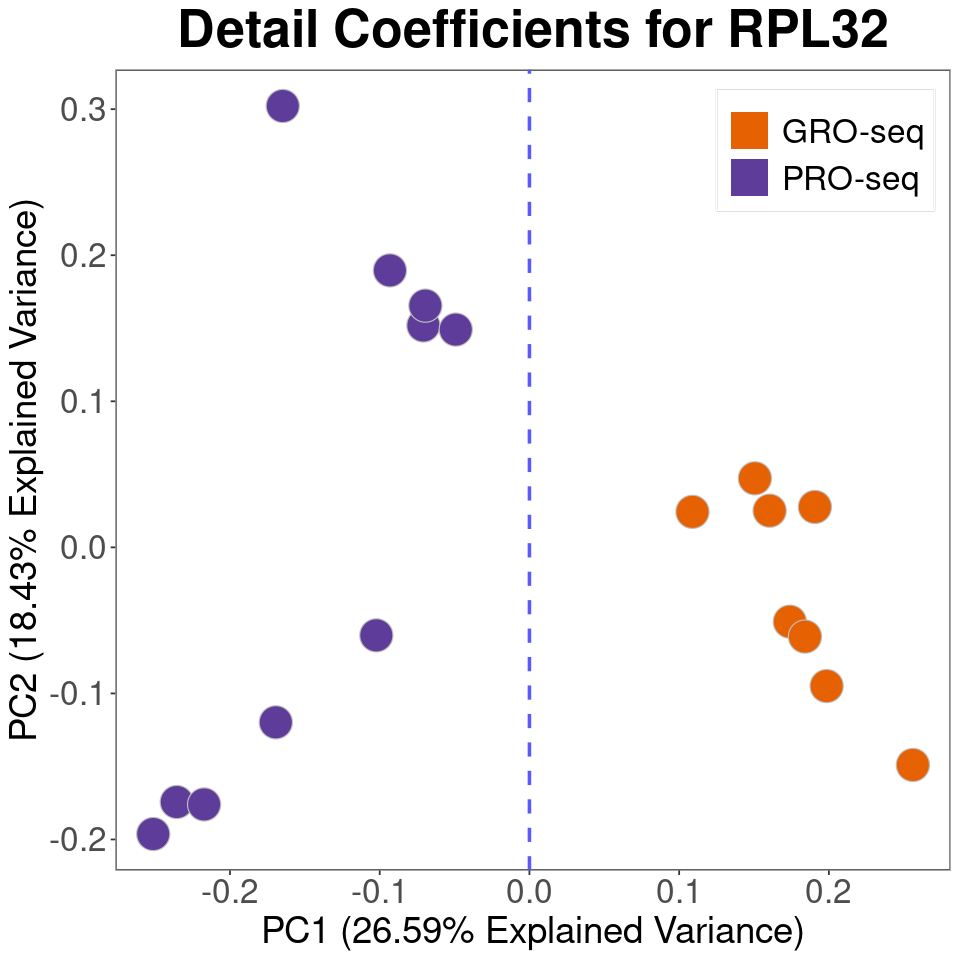

In [26]:
options(repr.plot.width=8, repr.plot.height=8)
rpl32_plot <- ggplot(rpl32_pc, aes(PC1, PC2,fill=Protocol)) +
        xlab("PC1 (26.59% Explained Variance)") +
        ylab("PC2 (18.43% Explained Variance)") + 
        ggtitle('Detail Coefficients for RPL32') +
        geom_point(size=9, shape=21,color="gray") +
        theme_bw() +
        geom_vline(xintercept=0, linetype="dashed", 
                    color = "blue", size=1, alpha=0.65) +
        guides(fill = guide_legend(override.aes = list(shape = 15, 
                                                   size = 10,
                                                  col=c('#e66101','#5e3c99')))) +
        scale_fill_manual(name="Protocol",
                          values = c('#e66101','#5e3c99'),
                         labels = c("GRO-seq", "PRO-seq")) +
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              panel.background = element_rect(colour = "black", size=0.75))+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),
              title = element_text(size = 26), 
              axis.title = element_text(size = 22), 
              axis.text = element_text(size = 20),
             legend.title =  element_blank(), 
             legend.text = element_text(size = 20)) +
        theme(
            panel.background = element_rect(fill = "white"), # bg of the panel
            panel.border = element_rect(colour = "gray", fill=NA),
            plot.background = element_rect(fill = "transparent",
                                           color = NA), # bg of the plot
            legend.key = element_rect(colour = "transparent",
                                      fill = "transparent"),
            legend.background = element_rect(fill = "transparent", 
                                             colour = 'white', linetype='solid'),
            legend.box.background = element_rect(fill = "transparent") 
            
        ) + theme(legend.position = c(0.85, 0.9))

rpl32_plot

### RPS3A PCA plot [Separates in PC space]

In [27]:
##subseting gene of interest
rps3a_pc <- as.data.frame(t(rbind(pc1[rownames(pc1) %in% 'RPS3A',],
                                pc2[rownames(pc2) %in% 'RPS3A',])))

colnames(rps3a_pc) <- c('PC1','PC2')
rownames(rps3a_pc) <- sample_ids$V1
rps3a_pc$Protocol <- sample_ids$V2
rps3a_pc$Library <- sample_ids$V3
rps3a_pc 

,PC1,PC2,Protocol,Library
,<dbl>,<dbl>,<fct>,<fct>
Chi_DMSO_S9.bedGraph,-0.019516777,-0.20463396,PRO,LIG
Chi_Nutlin_S10.bedGraph,-0.006270052,-0.22937137,PRO,LIG
DMSO_HCT116_RPI_26_S1_R1_001.bedGraph,-0.007784239,-0.24015338,PRO,LIG
DMSO-1_S1_R1_001.bedGraph,0.337745654,0.12634014,PRO,TSRT
DMSO-2_S2_R1_001.bedGraph,0.389587429,0.13982867,PRO,TSRT
i13_AGTCAA_L008_R1_001.bedGraph,-0.090838921,-0.06143412,GRO,LIG
i14_AGTTCC_L008_R1_001.bedGraph,-0.118960178,-0.05349801,GRO,LIG
i17_GTAGAG_L008_R1_001.bedGraph,-0.136144869,-0.04999780,GRO,LIG
i18_GTCCGC_L008_R1_001.bedGraph,-0.180291150,-0.02860211,GRO,LIG


In [28]:
subset(pca_results_all, geneID =='RPS3A')

,geneID,pc1,pc2,pc1_R_gro,pc1_L_gro,pc1_R_pro,pc1_L_pro
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
481,RPS3A,27.78,18.05,0,8,5,5


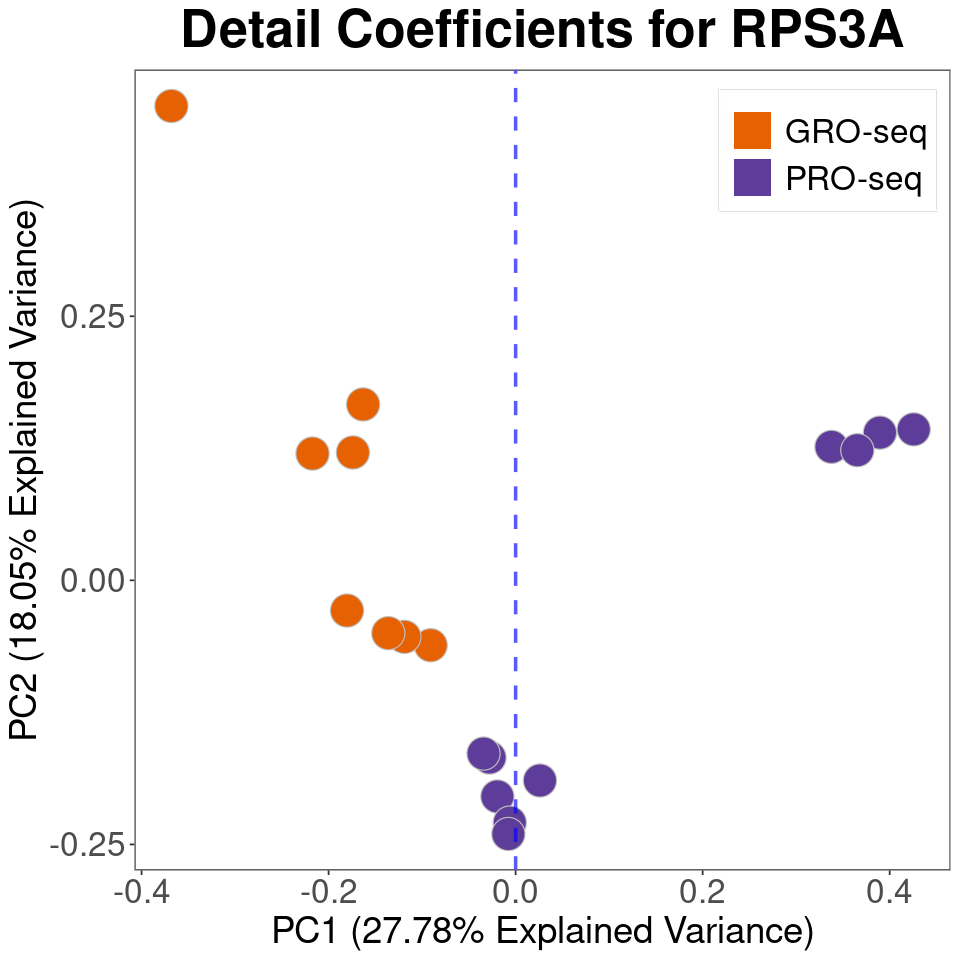

In [29]:
options(repr.plot.width=8, repr.plot.height=8)
rps3a_plot <- ggplot(rps3a_pc, aes(PC1, PC2,fill=Protocol)) +
        xlab("PC1 (27.78% Explained Variance)") +
        ylab("PC2 (18.05% Explained Variance)") + 
        ggtitle('Detail Coefficients for RPS3A') +
        geom_point(size=9, shape=21,color="gray") +
        theme_bw() +
        geom_vline(xintercept=0, linetype="dashed", 
                    color = "blue", size=1, alpha=0.65) +
        guides(fill = guide_legend(override.aes = list(shape = 15, 
                                                   size = 10,
                                                  col=c('#e66101','#5e3c99')))) +
        scale_fill_manual(name="Protocol",
                          values = c('#e66101','#5e3c99'),
                         labels = c("GRO-seq", "PRO-seq")) +
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              panel.background = element_rect(colour = "black", size=0.75))+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),
              title = element_text(size = 26), 
              axis.title = element_text(size = 22), 
              axis.text = element_text(size = 20),
             legend.title =  element_blank(),
             legend.text = element_text(size = 20)) +
        theme(
            panel.background = element_rect(fill = "white"), 
            panel.border = element_rect(colour = "gray", fill=NA),
            plot.background = element_rect(fill = "transparent", color = NA), 
            legend.key = element_rect(colour = "transparent", fill = "transparent"),
            legend.background = element_rect(fill = "transparent", 
                                             colour = 'white',
                                             linetype='solid'), 
            legend.box.background = element_rect(fill = "transparent") 
            
        ) + theme(legend.position = c(0.85, 0.9))

rps3a_plot

### CCND1 PCA plot [No separation of protocols]

In [30]:
##subseting gene of interest
ccnd1_pc <- as.data.frame(t(rbind(pc1[rownames(pc1) %in% 'CCND1',],
                                pc2[rownames(pc2) %in% 'CCND1',])))

colnames(ccnd1_pc) <- c('PC1','PC2')
rownames(ccnd1_pc) <-  sample_ids$V1
ccnd1_pc$Protocol <- sample_ids$V2
ccnd1_pc$Library <- sample_ids$V3
ccnd1_pc

,PC1,PC2,Protocol,Library
,<dbl>,<dbl>,<fct>,<fct>
Chi_DMSO_S9.bedGraph,0.37065678,-0.147273997,PRO,LIG
Chi_Nutlin_S10.bedGraph,0.31959961,-0.132546962,PRO,LIG
DMSO_HCT116_RPI_26_S1_R1_001.bedGraph,0.25927063,0.867221036,PRO,LIG
DMSO-1_S1_R1_001.bedGraph,-0.10208169,-0.023971744,PRO,TSRT
DMSO-2_S2_R1_001.bedGraph,-0.10760026,-0.021440618,PRO,TSRT
i13_AGTCAA_L008_R1_001.bedGraph,-0.07820308,-0.010372595,GRO,LIG
i14_AGTTCC_L008_R1_001.bedGraph,-0.09225082,-0.013233387,GRO,LIG
i17_GTAGAG_L008_R1_001.bedGraph,-0.10879462,-0.011690223,GRO,LIG
i18_GTCCGC_L008_R1_001.bedGraph,-0.12732099,-0.010934983,GRO,LIG


In [31]:
subset(pca_results_all, geneID =='CCND1')

,geneID,pc1,pc2,pc1_R_gro,pc1_L_gro,pc1_R_pro,pc1_L_pro
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
829,CCND1,29.44,22.32,0,8,6,4


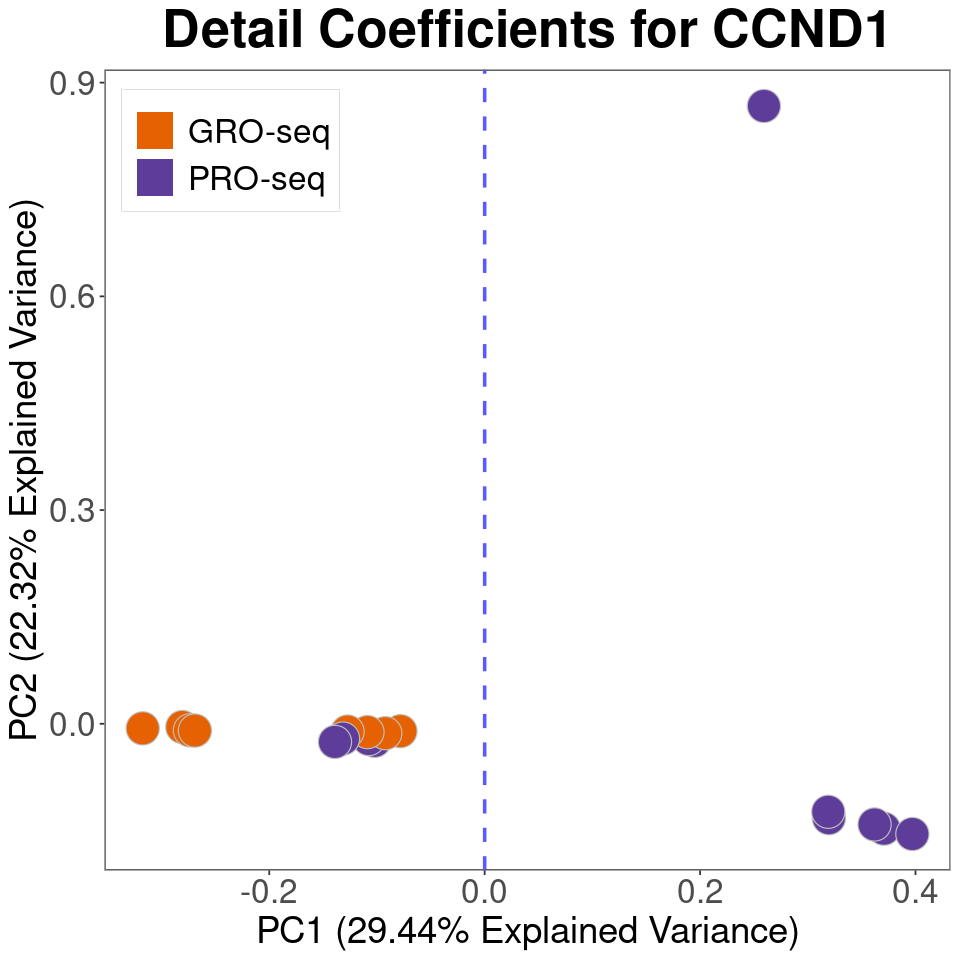

In [32]:
options(repr.plot.width=8, repr.plot.height=8)
ccnd1_plot <- ggplot(ccnd1_pc, aes(PC1, PC2,fill=Protocol)) +
        xlab("PC1 (29.44% Explained Variance)") +
        ylab("PC2 (22.32% Explained Variance)") + 
        ggtitle('Detail Coefficients for CCND1') +
        geom_point(size=9, shape=21,color="gray") +
        theme_bw() +
        geom_vline(xintercept=0, linetype="dashed", 
                    color = "blue", size=1, alpha=0.65) +
        guides(fill = guide_legend(override.aes = list(shape = 15, 
                                                   size = 10,
                                                  col=c('#e66101','#5e3c99')))) +
        scale_fill_manual(name="Protocol",
                          values = c('#e66101','#5e3c99'),
                         labels = c("GRO-seq", "PRO-seq")) +
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              panel.background = element_rect(colour = "black", size=0.75))+
        theme(plot.title = element_text(hjust = 0.5, face = "bold"),
              title = element_text(size = 26), 
              axis.title = element_text(size = 22), 
              axis.text = element_text(size = 20),
             legend.title =  element_blank(), 
             legend.text = element_text(size = 20)) +
        theme(
            panel.background = element_rect(fill = "white"), 
            panel.border = element_rect(colour = "gray", fill=NA),
            plot.background = element_rect(fill = "transparent", color = NA), 
            legend.key = element_rect(colour = "transparent", 
                                      fill = "transparent"),
            legend.background = element_rect(fill = "transparent",
                                             colour = 'white', 
                                             linetype='solid'), 
            legend.box.background = element_rect(fill = "transparent") 
            
        ) + theme(legend.position = c(0.15, 0.9))

ccnd1_plot 

In [33]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidyr_1.1.2   dplyr_1.0.2   cowplot_1.1.1 ggplot2_3.3.3

loaded via a namespace (and not attached):
 [1] magrittr_2.0.1   tidyselect_1.1.0 munsell_0.5.0    uuid_0.1-4      
 [5] colorspace_2.0-0 R6_2.5.0         rlang_0.4.10     tools_3.6.0     
 [9] grid_3.6.0       gtable_0.3.0     withr_2.3.0      htmltools_0.5.1 
[13] ellipsi